In [1]:
%load_ext autoreload 
%autoreload 2

In [24]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from models import AR_LSTM, compile_and_fit_tf


### data setup

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [5]:
area = "city of london"
monthly_data = utils.load_interpolated_data()

area_data = utils.get_area(monthly_data, area)


In [145]:
def format_data_for_RNN(area_data, cols, lookback, lookforward):
    train_df, test_df = train_test_split(area_data[cols],
                                         test_size=0.3,
                                         shuffle=False)

    # normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_df[cols] = scaler.fit_transform(train_df[cols])
    test_df[cols] = scaler.transform(test_df[cols])

    X_train, y_train = utils.create_windowed_dataset(train_df, cols, lookback,
                                                     lookforward)
    X_test, y_test = utils.create_windowed_dataset(test_df, cols, lookback,
                                                   lookforward)
    return train_df, test_df, X_train, y_train, X_test, y_test, scaler
    # return {'train_df':train_df, 'test_df':test_df, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test, 'scaler':scaler}


In [59]:
def plot_inputs_outputs(area_data,
                        ground_truth,
                        train_ts,
                        test_ts,
                        cols,
                        col_idx,
                        lookback,
                        lookforward,
                        fwd_offset,
                        title=''):
    """ Args: 
            area_data: dataframe containing dates
            ground_truth: dataframe containing ground truth data
            train_ts: np array containing time series in the shape 
                (n_samples, lookback timesteps, n_features)
            test_ts: np array containing time series in the shape 
                (n_samples, lookforward timesteps, n_features)
            cols (str list): list of strings of features 
            col_idx (int): index of the feature to be plotted 
            lookback (int): number of timesteps in the lookback 
            lookforward (int): number of timesteps in the lookforward
            fwd_idx (int): which forward prediction/sample to plot
            title (str)
    """
    # fwd_idx = fwd_idx % lookforward
    col = cols[col_idx]
    plt.plot(area_data.date, ground_truth[col])
    plt.plot(area_data.date[range(lookback, lookback + len(train_ts))],
             train_ts[:, col_idx])
    plt.plot(
        area_data.date[range(
            lookback * 2 + fwd_offset + lookforward + len(train_ts),
            lookback * 2 + fwd_offset + lookforward + len(train_ts) +
            len(test_ts))], test_ts[:, col_idx])
    plt.title(title)

In [144]:
def plot_cumulative(area_data,
                    ground_truth_diff,
                    train_ts_diff,
                    test_ts_diff,
                    cols,
                    col_idx,
                    lookback,
                    lookforward,
                    fwd_offset=0,
                    title=''):
    init_train_offset = area_data.loc[lookback, 'average_price']
    init_test_offset = area_data.loc[
            lookback * 2 + fwd_offset + lookforward + len(train_ts_diff), 'average_price']
    plot_inputs_outputs(area_data, 
                        np.cumsum(ground_truth_diff) + init_train_offset,
                        np.cumsum(train_ts_diff).reshape(-1, 1) + init_train_offset,
                        np.cumsum(test_ts_diff).reshape(-1, 1) + init_test_offset, 
                        cols, col_idx,
                        lookback, lookforward, fwd_offset, title)

## single-step prediction

### predict raw price

#### data setup

In [158]:
cols = ["average_price"]
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [159]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


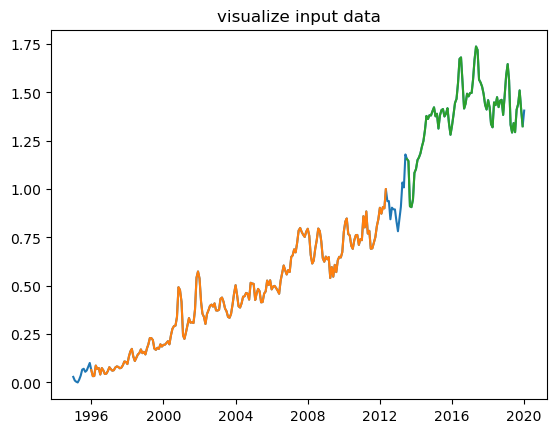

In [160]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [161]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 2s 81ms/step - loss: 0.2350 - mean_absolute_error: 0.4144 - val_loss: 1.0274 - val_mean_absolute_error: 1.0043
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0687 - mean_absolute_error: 0.2047 - val_loss: 0.1326 - val_mean_absolute_error: 0.3475
Epoch 3/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0147 - mean_absolute_error: 0.1058 - val_loss: 0.0121 - val_mean_absolute_error: 0.0871
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0166 - mean_absolute_error: 0.1129 - val_loss: 0.0776 - val_mean_absolute_error: 0.2573
Epoch 5/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0093 - mean_absolute_error: 0.0781 - val_loss: 0.1176 - val_mean_absolute_error: 0.3259
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0089 - mean_absolute_error: 0.0744 - val_loss: 0.0594 - val_mean_absolute_error: 0.2196
Epoch 7/50
7/7 [==================

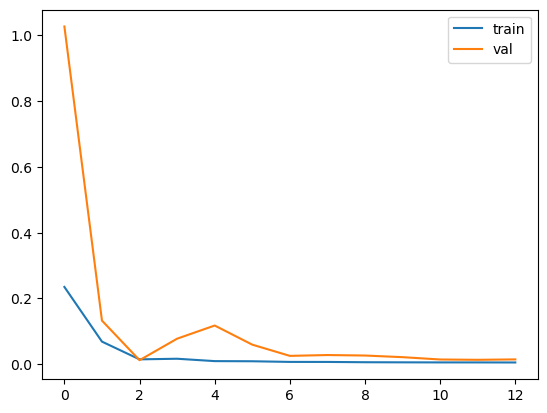

In [162]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

3/3 [==============================] - 0s 3ms/step


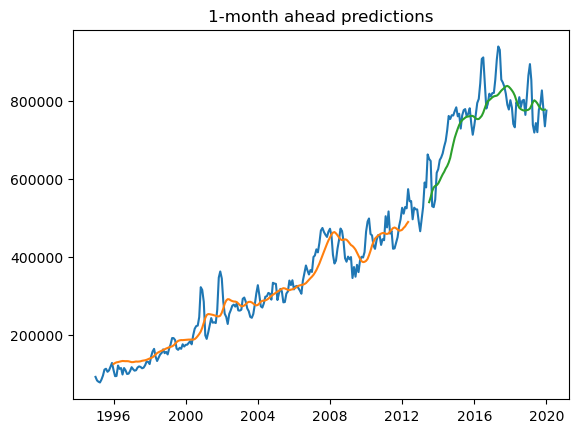

In [163]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


### multiple features

#### data

In [208]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [209]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 8)
(197, 1, 8)
(78, 12, 8)
(78, 1, 8)


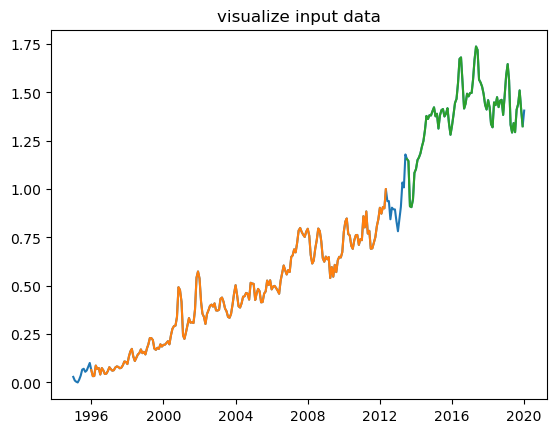

In [210]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [211]:
ar_lstm_model = AR_LSTM(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
7/7 [==============================] - 2s 70ms/step - loss: 0.1333 - mean_absolute_error: 0.2889 - val_loss: 0.6303 - val_mean_absolute_error: 0.6325
Epoch 2/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0408 - mean_absolute_error: 0.1506 - val_loss: 0.6235 - val_mean_absolute_error: 0.5877
Epoch 3/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0306 - mean_absolute_error: 0.1289 - val_loss: 0.4010 - val_mean_absolute_error: 0.4659
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0250 - mean_absolute_error: 0.1050 - val_loss: 0.4345 - val_mean_absolute_error: 0.5029
Epoch 5/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0236 - mean_absolute_error: 0.1005 - val_loss: 0.3575 - val_mean_absolute_error: 0.4584
Epoch 6/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0200 - mean_absolute_error: 0.0937 - val_loss: 0.3329 - val_mean_absolute_error: 0.4526
Epoch 7/100
7/7 [===========

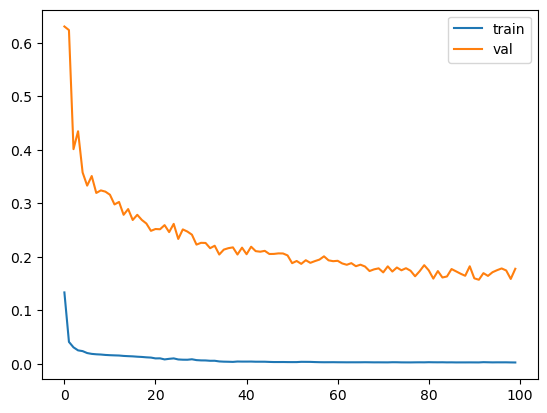

In [212]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [213]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 6ms/step


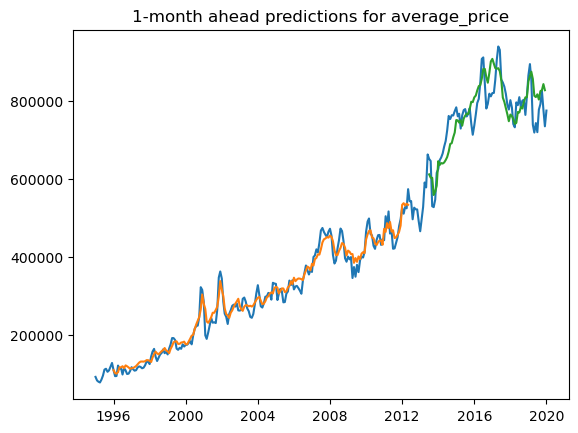

In [214]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


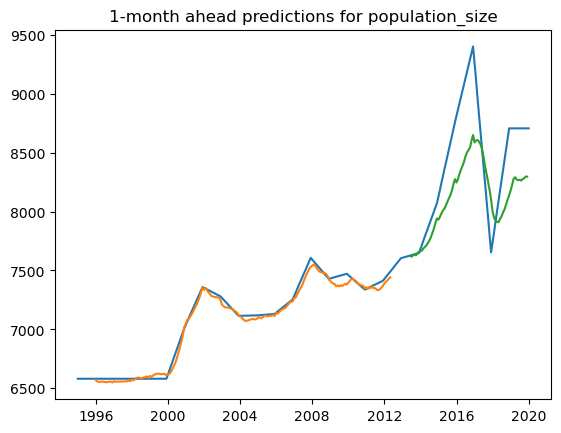

In [219]:
col_idx = 5
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


### predict diff

#### data

In [154]:
cols = ['average_price_d1']
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [148]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


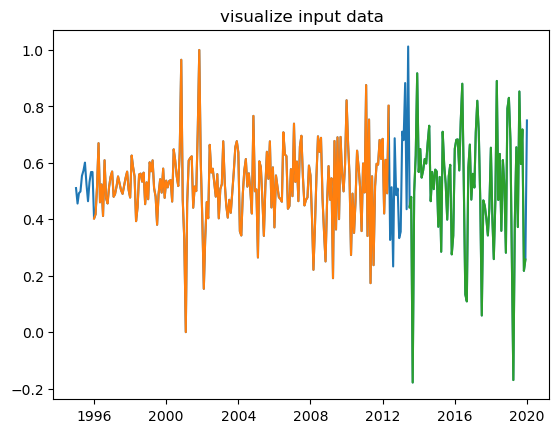

In [149]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [150]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 2s 56ms/step - loss: 0.2560 - mean_absolute_error: 0.4853 - val_loss: 0.1431 - val_mean_absolute_error: 0.3402
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0697 - mean_absolute_error: 0.2265 - val_loss: 0.0497 - val_mean_absolute_error: 0.1644
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0257 - mean_absolute_error: 0.1257 - val_loss: 0.0713 - val_mean_absolute_error: 0.2000
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0257 - mean_absolute_error: 0.1217 - val_loss: 0.0500 - val_mean_absolute_error: 0.1656
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0223 - mean_absolute_error: 0.1131 - val_loss: 0.0538 - val_mean_absolute_error: 0.1797
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0232 - mean_absolute_error: 0.1175 - val_loss: 0.0504 - val_mean_absolute_error: 0.1693
Epoch 7/50
7/7 [==================

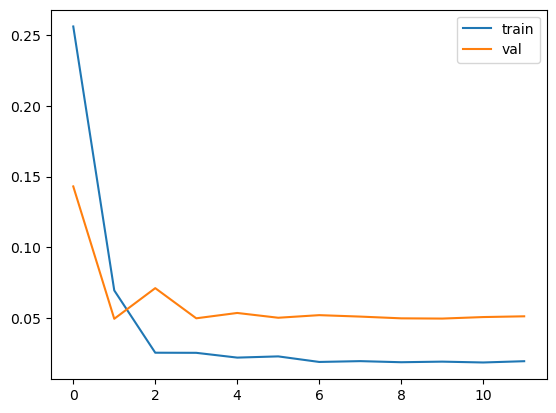

In [151]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [155]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 3ms/step


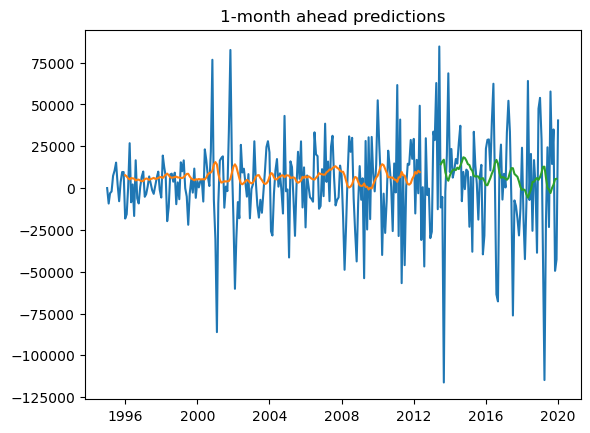

In [156]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=col_idx,
                    title='1-month ahead predictions')

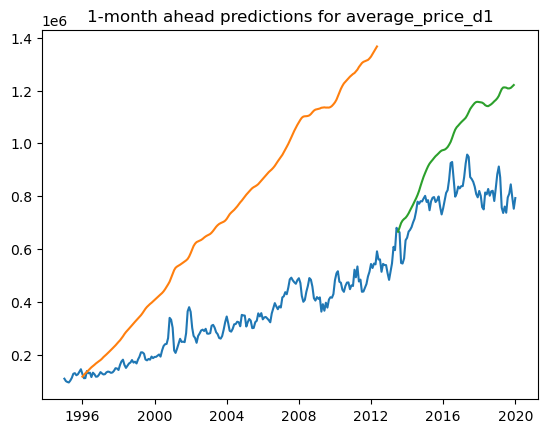

In [157]:
col_idx = 0
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


## autoregressive prediction

### predict raw

#### data setup

In [71]:
cols = ["average_price"]
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [72]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


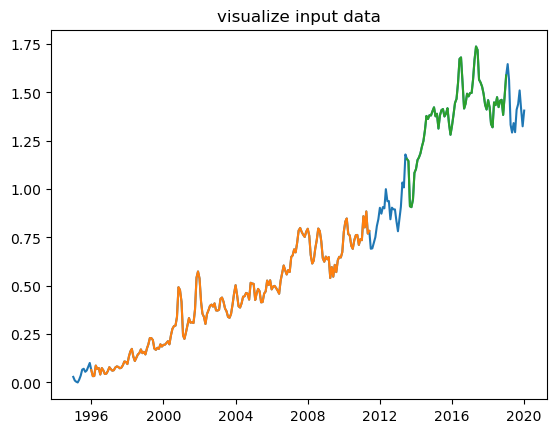

In [73]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [74]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 7s 309ms/step - loss: 0.2359 - mean_absolute_error: 0.4248 - val_loss: 1.5582 - val_mean_absolute_error: 1.2409
Epoch 2/50
6/6 [==============================] - 0s 32ms/step - loss: 0.1180 - mean_absolute_error: 0.2844 - val_loss: 0.5294 - val_mean_absolute_error: 0.7183
Epoch 3/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0279 - mean_absolute_error: 0.1372 - val_loss: 0.0284 - val_mean_absolute_error: 0.1343
Epoch 4/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0210 - mean_absolute_error: 0.1226 - val_loss: 0.2600 - val_mean_absolute_error: 0.4973
Epoch 5/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0195 - mean_absolute_error: 0.1107 - val_loss: 0.3391 - val_mean_absolute_error: 0.5698
Epoch 6/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0155 - mean_absolute_error: 0.0977 - val_loss: 0.1584 - val_mean_absolute_error: 0.3825
Epoch 7/50
6/6 [=================

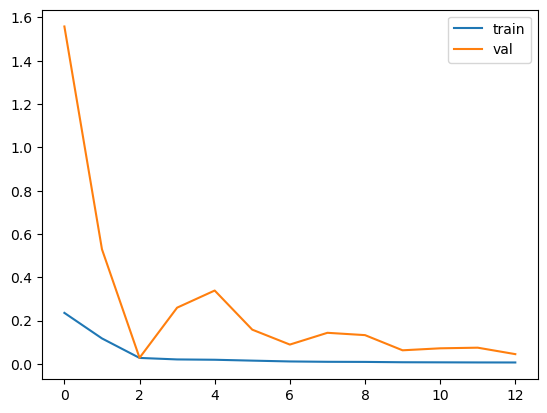

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [ ]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


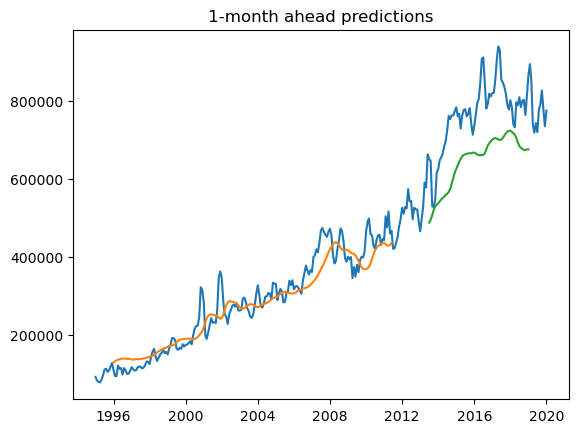

In [77]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')

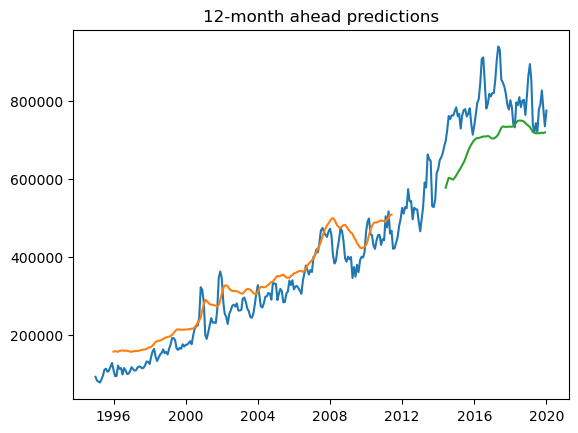

In [78]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-month ahead predictions')


### multiple features

#### data setup

In [196]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [197]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 8)
(186, 12, 8)
(67, 12, 8)
(67, 12, 8)


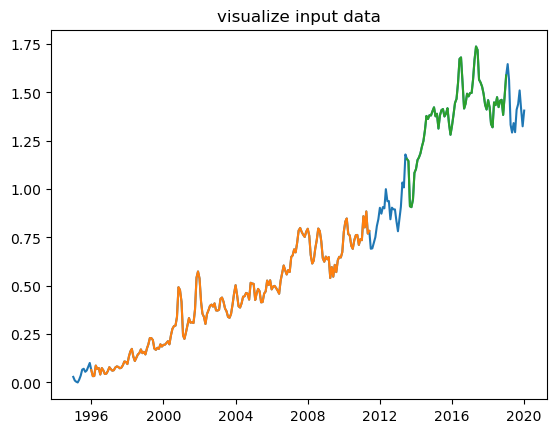

In [198]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [199]:
ar_lstm_model = AR_LSTM(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
6/6 [==============================] - 4s 158ms/step - loss: 0.1253 - mean_absolute_error: 0.2769 - val_loss: 0.8441 - val_mean_absolute_error: 0.6646
Epoch 2/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0516 - mean_absolute_error: 0.1806 - val_loss: 0.8852 - val_mean_absolute_error: 0.7062
Epoch 3/100
6/6 [==============================] - 0s 63ms/step - loss: 0.0326 - mean_absolute_error: 0.1380 - val_loss: 0.8659 - val_mean_absolute_error: 0.6639
Epoch 4/100
6/6 [==============================] - 0s 65ms/step - loss: 0.0286 - mean_absolute_error: 0.1186 - val_loss: 0.8148 - val_mean_absolute_error: 0.6540
Epoch 5/100
6/6 [==============================] - 0s 73ms/step - loss: 0.0244 - mean_absolute_error: 0.1093 - val_loss: 0.7504 - val_mean_absolute_error: 0.6406
Epoch 6/100
6/6 [==============================] - 0s 54ms/step - loss: 0.0235 - mean_absolute_error: 0.1058 - val_loss: 0.7920 - val_mean_absolute_error: 0.6548
Epoch 7/100
6/6 [==========

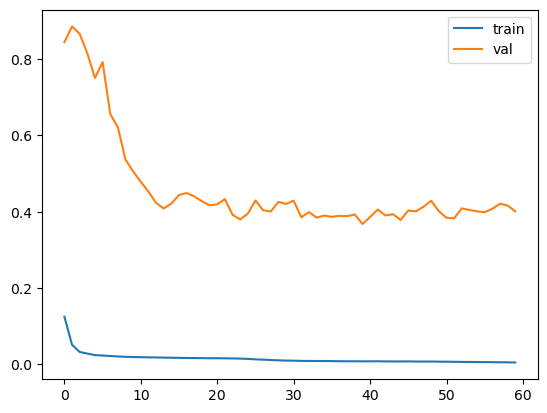

In [200]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [201]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 8ms/step


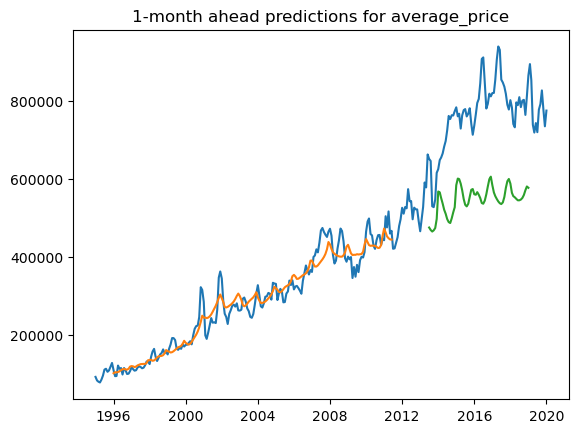

In [202]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


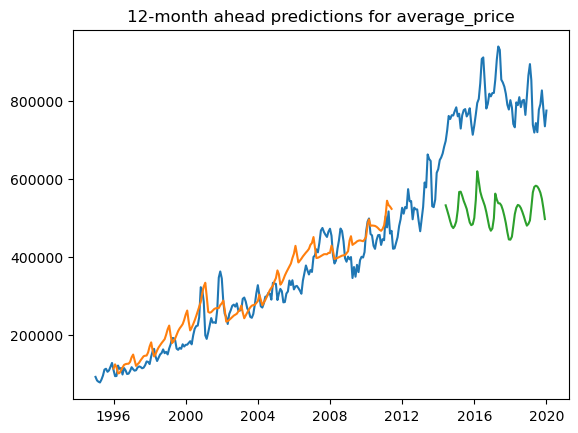

In [203]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


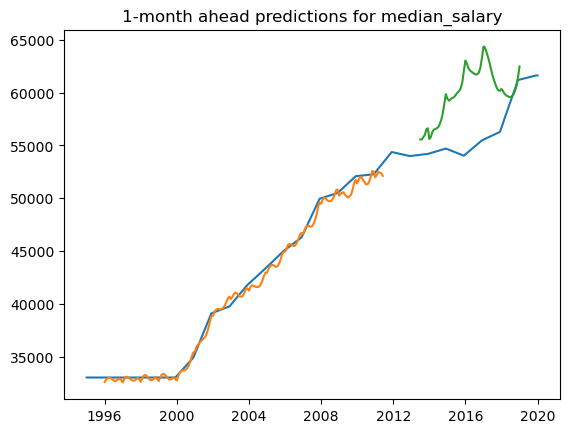

In [207]:
col_idx = 4
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


### predict diff

#### data

In [116]:
cols = ['average_price_d1']
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [117]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


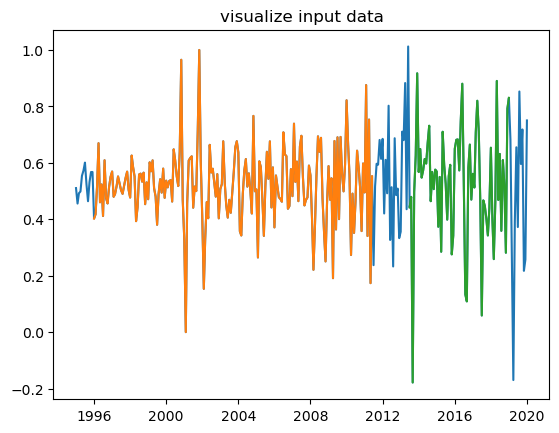

In [118]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [119]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 7s 215ms/step - loss: 0.1558 - mean_absolute_error: 0.3661 - val_loss: 0.0632 - val_mean_absolute_error: 0.2094
Epoch 2/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0359 - mean_absolute_error: 0.1506 - val_loss: 0.0670 - val_mean_absolute_error: 0.2001
Epoch 3/50
6/6 [==============================] - 0s 44ms/step - loss: 0.0252 - mean_absolute_error: 0.1192 - val_loss: 0.0454 - val_mean_absolute_error: 0.1682
Epoch 4/50
6/6 [==============================] - 0s 60ms/step - loss: 0.0255 - mean_absolute_error: 0.1270 - val_loss: 0.0462 - val_mean_absolute_error: 0.1705
Epoch 5/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0201 - mean_absolute_error: 0.1060 - val_loss: 0.0421 - val_mean_absolute_error: 0.1541
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0196 - mean_absolute_error: 0.1024 - val_loss: 0.0429 - val_mean_absolute_error: 0.1553
Epoch 7/50
6/6 [=================

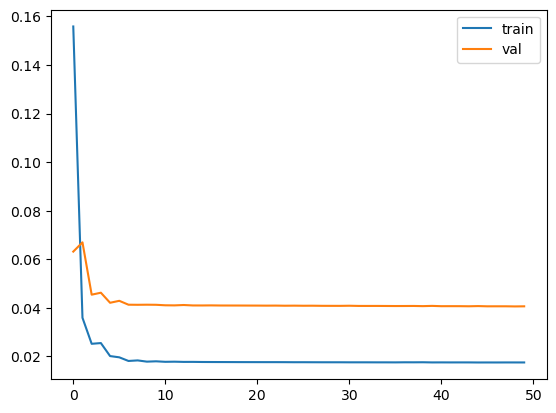

In [120]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [121]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 6ms/step


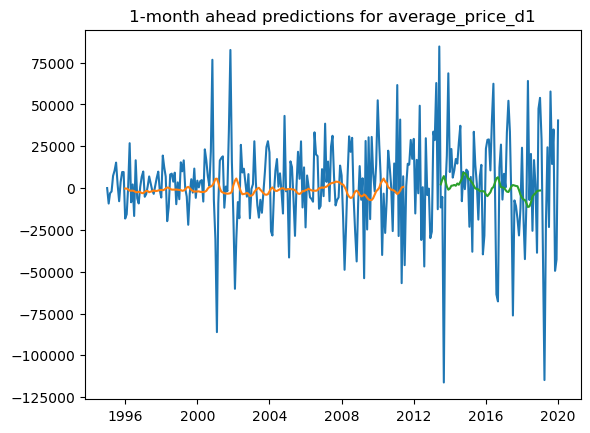

In [122]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


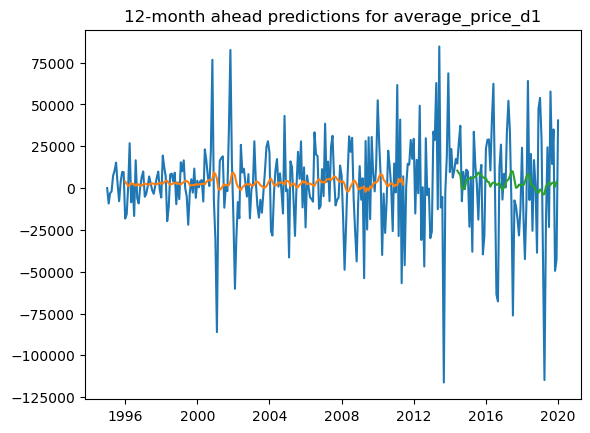

In [123]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


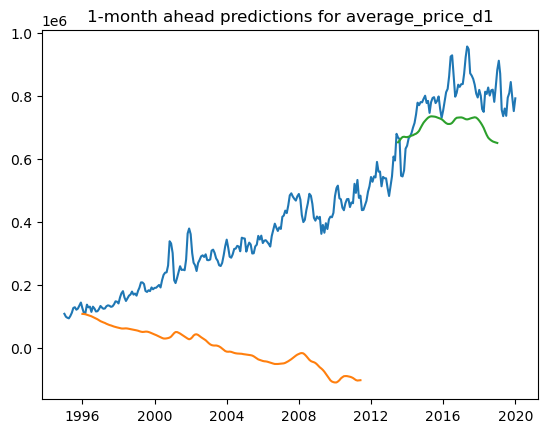

In [146]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


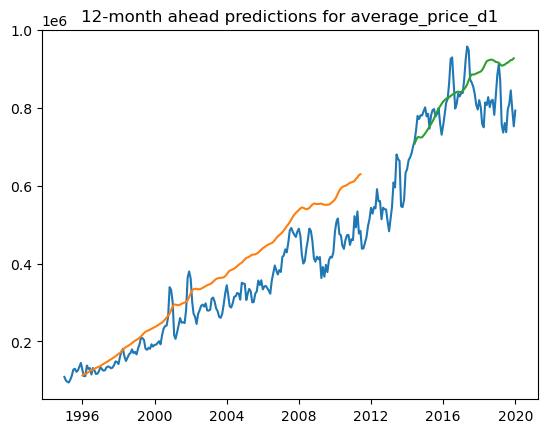

In [142]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_12mo_train_rescaled,
                test_ts_diff=pred_12mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=11,
                title=f'12-month ahead predictions for {cols[col_idx]}')
